In [29]:
import json
import csv

In [23]:
def extract_parentesis(s):
    res = s.split()[1]
    return res[1:-1]

def extract_both(s):
    split = s.split()
    return split[0], split[1][1:-1]

def moment_features(pref, in_dict, out_dict={}):
    ellipse_major, ellipse_minor = in_dict['Ellipse Semi-Major/Minor axis'].split(',')

    out_dict['moments_' + pref + '_ellipse_major'] = float(ellipse_major)
    out_dict['moments_' + pref + '_ellipse_minor'] = float(ellipse_minor)
    out_dict['moments_' + pref + '_ellipse_eccentricity'] = float(in_dict['Ellipse eccentricity'])
    out_dict['moments_' + pref + '_ellipse_intensity'] = float(extract_parentesis(in_dict['Ellipse intensity']))
    out_dict['moments_' + pref + '_ellipse_angle'] = float(in_dict[u'Ellipse angle'])

    centroid_x, centroid_y = in_dict[u'Centroid'].split(',')
    out_dict['moments_' + pref + '_ellipse_centroid_x'] = float(centroid_x)
    out_dict['moments_' + pref + '_ellipse_centroid_y'] = float(centroid_y)

    for i in range(1, 9):
        #v1, v2 = extract_both(in_dict['I%d' % i])
        #out_dict['moments_' + pref + '_I%d_1' % i] = float(v1)
        #out_dict['moments_' + pref + '_I%d_2' % i] = float(v2)
        v2 = extract_parentesis(in_dict['I%d' % i])
        out_dict['moments_' + pref + '_I%d' % i] = float(v2)

def phash_features(in_dict, out_dict={}):
    for k, phdict in in_dict.items():
        k1, k2 = k.lower().split(', ')
        for phk, phv in phdict.items():
            phv1, phv2 = phv.split(', ')
            out_dict['phash_%s_%s' % (k1, phk.lower())] = float(phv1)
            out_dict['phash_%s_%s' % (k2, phk.lower())] = float(phv2)
        
def image_stats_features(pref, in_dict, out_dict={}):
    out_dict['imstat_' + pref + '_skewness'] = float(in_dict['skewness'])
    out_dict['imstat_' + pref + '_min'] = float(extract_parentesis(in_dict['min']))
    out_dict['imstat_' + pref + '_max'] = float(extract_parentesis(in_dict['max']))
    out_dict['imstat_' + pref + '_mean'] = float(extract_parentesis(in_dict['mean']))
    out_dict['imstat_' + pref + '_std'] = float(extract_parentesis(in_dict['standard deviation']))
    out_dict['imstat_' + pref + '_entropy'] = float(in_dict['entropy'])
    out_dict['imstat_' + pref + '_kurtosis'] = float(in_dict['kurtosis'])

def chromaticity_features(in_dict, out_dict={}):
    for k, v in in_dict.items():
        k = k.split()[0]
        v1, v2 = eval(v)
        out_dict['croma_%s_1' % k] = v1
        out_dict['croma_%s_2' % k] = v2    

def number_pixels(s):
    if type(s) in [int, float]:
        return s
    if s.endswith('K'):
        return 1000 * float(s[:-1])

    raise Exception('number_pixels: unknown format' + s)

def file_size(s):
    if s.endswith('KB'):
        return 1024 * float(s[:-2])
    elif s.endswith('B'):
        return float(s[:-1])
    elif s.endswith('MB'):
        return 1024 * 1024 * float(s[:-2])
    raise Exception('file_size: unknown format ' + s)

def process_line(line):
    image_id, features = line.split('\t', maxsplit=1)
    features = json.loads(features)

    res_dict = {'_id': image_id}
    res_dict['alpha_color'] = features['Alpha color']
    res_dict['bg_color'] =  features['Background color']
    
    is_gray = features[u'Type'] in [u'Grayscale', u'Bilevel']
    if is_gray:
        res_dict['color'] = False
        moment_features('overall', features[u'Channel moments']['Gray'], res_dict)
        moment_features('red', features[u'Channel moments']['Gray'], res_dict)
        moment_features('green', features[u'Channel moments']['Gray'], res_dict)
        moment_features('blue', features[u'Channel moments']['Gray'], res_dict)

        image_stats_features('overall', features[u'Channel statistics']['Gray'], res_dict)
        image_stats_features('red', features[u'Channel statistics']['Gray'], res_dict)
        image_stats_features('green', features[u'Channel statistics']['Gray'], res_dict)
        image_stats_features('blue', features[u'Channel statistics']['Gray'], res_dict)
    else:
        res_dict['color'] = True
        moment_features('overall', features[u'Image moments']['Overall'], res_dict)
        moment_features('red', features[u'Channel moments']['Red'], res_dict)
        moment_features('green', features[u'Channel moments']['Green'], res_dict)
        moment_features('blue', features[u'Channel moments']['Blue'], res_dict)

        image_stats_features('overall', features[u'Image statistics']['Overall'], res_dict)
        image_stats_features('red', features[u'Channel statistics']['Red'], res_dict)
        image_stats_features('green', features[u'Channel statistics']['Green'], res_dict)
        image_stats_features('blue', features[u'Channel statistics']['Blue'], res_dict)

    phash_features(features[u'Channel perceptual hash'], res_dict)
    res_dict['no_pixels'] = number_pixels(features[u'Number pixels'])
    res_dict['filesize'] = file_size(features[u'Filesize'])

    res_dict['quality'] = features[u'Quality']
    res_dict['geometry'] = features[u'Geometry'][:-4]
    res_dict['type'] = features[u'Type']
    res_dict['colorspace'] = features[u'Colorspace']

    props = features[u'Properties']
    res_dict['date'] = props[u'date:modify']
    #res_dict['signature'] = props[u'signature']

    return res_dict

In [24]:
header = ['_id', 'alpha_color', 'bg_color', 'color', 'colorspace', 'date', 'filesize', 'geometry', 
          'imstat_blue_entropy', 'imstat_blue_kurtosis', 'imstat_blue_max', 'imstat_blue_mean', 
          'imstat_blue_min', 'imstat_blue_skewness', 'imstat_blue_std', 'imstat_green_entropy',
          'imstat_green_kurtosis', 'imstat_green_max', 'imstat_green_mean', 'imstat_green_min',
          'imstat_green_skewness', 'imstat_green_std', 'imstat_overall_entropy', 'imstat_overall_kurtosis',
          'imstat_overall_max', 'imstat_overall_mean', 'imstat_overall_min', 'imstat_overall_skewness',
          'imstat_overall_std', 'imstat_red_entropy', 'imstat_red_kurtosis', 'imstat_red_max',
          'imstat_red_mean', 'imstat_red_min', 'imstat_red_skewness', 'imstat_red_std', 'moments_blue_I1',
          'moments_blue_I2', 'moments_blue_I3', 'moments_blue_I4', 'moments_blue_I5', 'moments_blue_I6',
          'moments_blue_I7', 'moments_blue_I8', 'moments_blue_ellipse_angle', 'moments_blue_ellipse_centroid_x',
          'moments_blue_ellipse_centroid_y', 'moments_blue_ellipse_eccentricity', 'moments_blue_ellipse_intensity',
          'moments_blue_ellipse_major', 'moments_blue_ellipse_minor', 'moments_green_I1', 'moments_green_I2',
          'moments_green_I3', 'moments_green_I4', 'moments_green_I5', 'moments_green_I6', 'moments_green_I7',
          'moments_green_I8', 'moments_green_ellipse_angle', 'moments_green_ellipse_centroid_x', 
          'moments_green_ellipse_centroid_y', 'moments_green_ellipse_eccentricity', 
          'moments_green_ellipse_intensity', 'moments_green_ellipse_major', 'moments_green_ellipse_minor',
          'moments_overall_I1', 'moments_overall_I2', 'moments_overall_I3', 'moments_overall_I4', 
          'moments_overall_I5', 'moments_overall_I6', 'moments_overall_I7', 'moments_overall_I8', 
          'moments_overall_ellipse_angle', 'moments_overall_ellipse_centroid_x', 
          'moments_overall_ellipse_centroid_y', 'moments_overall_ellipse_eccentricity', 
          'moments_overall_ellipse_intensity', 'moments_overall_ellipse_major', 'moments_overall_ellipse_minor',
          'moments_red_I1', 'moments_red_I2', 'moments_red_I3', 'moments_red_I4', 'moments_red_I5', 
          'moments_red_I6', 'moments_red_I7', 'moments_red_I8', 'moments_red_ellipse_angle', 
          'moments_red_ellipse_centroid_x', 'moments_red_ellipse_centroid_y', 'moments_red_ellipse_eccentricity', 
          'moments_red_ellipse_intensity', 'moments_red_ellipse_major', 'moments_red_ellipse_minor', 
          'no_pixels', 'phash_blue_ph1', 'phash_blue_ph2', 'phash_blue_ph3', 'phash_blue_ph4', 'phash_blue_ph5', 
          'phash_blue_ph6', 'phash_blue_ph7', 'phash_chroma_ph1', 'phash_chroma_ph2', 'phash_chroma_ph3', 
          'phash_chroma_ph4', 'phash_chroma_ph5', 'phash_chroma_ph6', 'phash_chroma_ph7', 'phash_green_ph1',
          'phash_green_ph2', 'phash_green_ph3', 'phash_green_ph4', 'phash_green_ph5', 'phash_green_ph6',
          'phash_green_ph7', 'phash_hue_ph1', 'phash_hue_ph2', 'phash_hue_ph3', 'phash_hue_ph4', 'phash_hue_ph5',
          'phash_hue_ph6', 'phash_hue_ph7', 'phash_luma_ph1', 'phash_luma_ph2', 'phash_luma_ph3', 'phash_luma_ph4',
          'phash_luma_ph5', 'phash_luma_ph6', 'phash_luma_ph7', 'phash_red_ph1', 'phash_red_ph2', 'phash_red_ph3',
          'phash_red_ph4', 'phash_red_ph5', 'phash_red_ph6', 'phash_red_ph7', 'quality', 'type']

In [30]:
csv_res_file = open('imagemagick_features_res.csv', 'w')

writer = csv.DictWriter(csv_res_file, fieldnames=header)

In [31]:
writer.writeheader()

In [32]:
from tqdm import tqdm

In [33]:
with open('imagemagick_features.txt') as f:
    for line in tqdm(f):
        d = process_line(line.strip())
        writer.writerow(d)

692156it [07:34, 1522.07it/s]


In [34]:
csv_res_file.flush()
csv_res_file.close()

In [35]:
import re

import numpy as np
import pandas as pd

import os

from tqdm import tqdm
import gc

from sklearn.utils import shuffle
from sklearn.metrics import log_loss

import feather

In [116]:
df_train = pd.read_json('data/train.json')


In [197]:
df_test = pd.read_json('data/test.json')


In [117]:
def extract_file_name(url):
    return url[url.rfind('/')+1:]

In [118]:
np.random.seed(1)
folds = np.random.choice([0, 1, 2, 3, 4, 5], size=len(df_train))
df_train['fold'] = folds.astype('uint8')

In [119]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
df_train.interest_level = df_train.interest_level.apply(lambda x: interest_level_map.get(x, -1))

In [120]:
images_train = []

for row in df_train.itertuples():
    id = row.listing_id
    fold = row.fold
    lev = row.interest_level
    for p in row.photos:
        path = extract_file_name(p)
        images_train.append((id, path, lev, fold))

In [121]:
df_images_train = pd.DataFrame(images_train, columns=['listing_id', 'image', 'interest_level', 'fold'])
df_images_train.sample(n=5)

,listing_id,image,interest_level,fold
48745,6844210,6844210_02cbfc2fa16da927305118fcd83aa434.jpg,1,0
136193,7134435,7134435_885ac210b226103408b2dd92ec247a6c.jpg,0,1
174944,7159349,7159349_23fb954c529b048204dec432e347e143.jpg,1,5
96446,7089849,7089849_1ecde35675aed2d4c2c0fa95d8e646a7.jpg,0,0
11971,6882010,6882010_acc0ecd59f7c530156febd6908ccb8b7.jpg,1,0


In [198]:
images_test = []

for row in df_test.itertuples():
    id = row.listing_id
    for p in row.photos:
        path = extract_file_name(p)
        images_test.append((id, path))

In [199]:
df_images_test = pd.DataFrame(images_test, columns=['listing_id', 'image'])
df_images_test.sample(n=5)

,listing_id,image
173889,7090665,7090665_7175ce1f0c8746ab4d89e4f37c270e10.jpg
70543,6879043,6879043_085b7b2d435873a7846fcb3d36e8e042.jpg
247810,6958897,6958897_41dbcb278bf7d333dec9849ebd1bc6c4.jpg
287339,7173404,7173404_fdde48b40f4151de1c01d2523a294f53.jpg
52162,6946356,6946356_bd130121417bda6b2a03713468ee90d3.jpg


In [122]:
for i in [0, 1, 2]:
    df_images_train['interest_%s' % i] = (df_images_train.interest_level == i).astype('uint8')

In [123]:
train_images = set(df_images_train.image)

In [56]:
dtypes = {'_id': 'O',
     'alpha_color': 'O',
     'bg_color': 'O',
     'color': 'bool',
     'colorspace': 'O',
     'date': 'O',
     'geometry': 'O',
     'type': 'O'}

for t in header:
    if t not in dtypes:
        dtypes[t] = 'float32'

In [147]:
df_im = pd.read_csv('imagemagick_features_res.csv', dtype=dtypes)
del df_im['alpha_color']
del df_im['bg_color']
del df_im['color']
del df_im['colorspace']
del df_im['type']
del df_im['quality']

In [148]:
df_im.date = pd.to_datetime(df_im.date)

In [149]:
from_start = (df_im.date - df_im.date.min())

In [150]:
sec_from_start = from_start / np.timedelta64(1, 's')
df_im['seconds_from_min'] = sec_from_start.astype('float32')

In [151]:
del df_im['date']

In [152]:
df_im['train'] = df_im._id.isin(train_images)

In [153]:
time_train = df_im[df_im.train == True].seconds_from_min
time_test = df_im[df_im.train == False].seconds_from_min

In [101]:
import seaborn as sns
%matplotlib inline

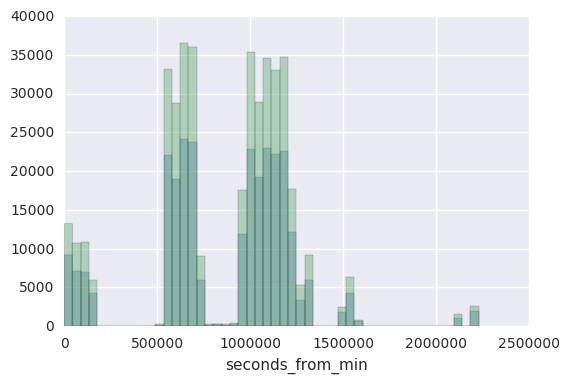

In [103]:
sns.distplot(time_train, kde=False)
sns.distplot(time_test, kde=False)

In [154]:
df_train = df_images_train.merge(df_im, left_on='image', right_on='_id')
del df_train['train']
del df_train['_id']

In [214]:
df_test = df_images_test.merge(df_im, left_on='image', right_on='_id')
del df_test['_id']

In [156]:
df_fold012 = df_train[df_train.fold <= 2].reset_index(drop=1)
df_fold345 = df_train[df_train.fold >= 3].reset_index(drop=1)

In [157]:
def fit_mtv(df, target_col, cat_col, C):
    m0 = (df[target_col] == 1).mean()

    cnt = df[df[target_col] == 1][cat_col].value_counts()
    cnt_all = df[cat_col].value_counts()

    probs = (cnt + C * m0) / (cnt_all + C)
    return probs, m0

def transform_mtv(df_target, probs, m0):
    probs_targ = probs[df_target[cat_col]].reset_index(drop=1)
    probs_targ.fillna(m0, inplace=1)
    return probs_targ

In [159]:
C = 12
cat_col = 'geometry'

df1 = df_fold012
df2 = df_fold345

for target_col in ['interest_0', 'interest_1', 'interest_2']:
    res_name = '%s_%s_mtv' % (cat_col, target_col)

    probs, m0 = fit_mtv(df1, target_col, cat_col, C=C)
    df2[res_name] = transform_mtv(df2, probs, m0)

    probs, m0 = fit_mtv(df2, target_col, cat_col, C=C)
    df1[res_name] = transform_mtv(df1, probs, m0)

In [217]:
C = 12
cat_col = 'geometry'

df1 = df_train
df2 = df_test

for target_col in ['interest_0', 'interest_1', 'interest_2']:
    res_name = '%s_%s_mtv' % (cat_col, target_col)

    probs, m0 = fit_mtv(df1, target_col, cat_col, C=C)
    df2[res_name] = transform_mtv(df2, probs, m0)

In [164]:
exclude = {'listing_id', 'image', 'interest_level', 'fold',
           'interest_0', 'interest_1', 'interest_2', 'geometry'}

features = sorted(set(df_fold012.columns) - exclude)

In [168]:
import xgboost as xgb

In [200]:
X_1 = df_fold012[features]
y_1 = df_fold012.interest_level

In [201]:
dfold1 = xgb.DMatrix(X_1, label=y_1, feature_names=features)
del X_1, y_1

In [202]:
X_2 = df_fold345[features]
y_2 = df_fold345.interest_level

In [203]:
dfold2 = xgb.DMatrix(X_2, label=y_2, feature_names=features)
del X_2, y_2

In [204]:
watchlist = [(dfold1, 'train'), (dfold2, 'val')]

In [205]:
xgb_pars = {
    'eta': 0.15,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
# not deafauts
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 3,
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

In [206]:
n_estimators = 100
model2 = xgb.train(xgb_pars, dfold1, num_boost_round=n_estimators, verbose_eval=1,
                 evals=watchlist)

[0]	train-mlogloss:1.02967	val-mlogloss:1.02994
[1]	train-mlogloss:0.975435	val-mlogloss:0.976409
[2]	train-mlogloss:0.934338	val-mlogloss:0.936016
[3]	train-mlogloss:0.900403	val-mlogloss:0.902528
[4]	train-mlogloss:0.872669	val-mlogloss:0.874804
[5]	train-mlogloss:0.850392	val-mlogloss:0.852463
[6]	train-mlogloss:0.832121	val-mlogloss:0.834516
[7]	train-mlogloss:0.817694	val-mlogloss:0.820551
[8]	train-mlogloss:0.805488	val-mlogloss:0.808689
[9]	train-mlogloss:0.79529	val-mlogloss:0.798727
[10]	train-mlogloss:0.787322	val-mlogloss:0.791373
[11]	train-mlogloss:0.780661	val-mlogloss:0.78531
[12]	train-mlogloss:0.7747	val-mlogloss:0.77985
[13]	train-mlogloss:0.76962	val-mlogloss:0.775377
[14]	train-mlogloss:0.765557	val-mlogloss:0.771913
[15]	train-mlogloss:0.762058	val-mlogloss:0.769185
[16]	train-mlogloss:0.758782	val-mlogloss:0.766617
[17]	train-mlogloss:0.75578	val-mlogloss:0.764403
[18]	train-mlogloss:0.75345	val-mlogloss:0.762674
[19]	train-mlogloss:0.751272	val-mlogloss:0.761169


In [188]:
print('feature importance:')

scores = model2.get_score(importance_type='gain')

for n, s in sorted(scores.items(), key=lambda x: -x[1]):
    print(' - %s: %.4f' % (n, s))

not_used = set(features) - scores.keys()
print('not used features: %s' % not_used)

feature importance:
 - seconds_from_min: 22.8870
 - geometry_interest_0_mtv: 12.9843
 - geometry_interest_1_mtv: 10.4574
 - geometry_interest_2_mtv: 10.4289
 - filesize: 7.0023
 - no_pixels: 6.3033
 - moments_red_I2: 5.1933
 - moments_overall_ellipse_major: 5.1474
 - moments_red_I1: 5.1313
 - imstat_blue_min: 5.0430
 - moments_blue_ellipse_centroid_y: 5.0327
 - moments_red_ellipse_minor: 5.0324
 - moments_green_ellipse_intensity: 5.0166
 - moments_red_ellipse_centroid_y: 5.0159
 - moments_blue_ellipse_intensity: 5.0025
 - imstat_overall_min: 4.9704
 - moments_overall_ellipse_centroid_y: 4.9698
 - moments_green_ellipse_centroid_y: 4.9674
 - moments_green_ellipse_major: 4.9667
 - phash_luma_ph2: 4.9616
 - phash_red_ph2: 4.9497
 - imstat_red_skewness: 4.9235
 - phash_green_ph2: 4.9191
 - moments_red_ellipse_major: 4.8981
 - phash_hue_ph2: 4.8980
 - moments_overall_I1: 4.8616
 - imstat_green_min: 4.8406
 - phash_blue_ph1: 4.8283
 - moments_red_ellipse_intensity: 4.7816
 - moments_green_ell

In [207]:
ypred2 = model2.predict(dfold2)

In [208]:
watchlist = [(dfold2, 'train'), (dfold1, 'val')]

In [209]:
model1 = xgb.train(xgb_pars, dfold2, num_boost_round=n_estimators, verbose_eval=1,
                 evals=watchlist)

[0]	train-mlogloss:1.03074	val-mlogloss:1.03314
[1]	train-mlogloss:0.972641	val-mlogloss:0.977098
[2]	train-mlogloss:0.929253	val-mlogloss:0.936204
[3]	train-mlogloss:0.894003	val-mlogloss:0.902996
[4]	train-mlogloss:0.864896	val-mlogloss:0.875668
[5]	train-mlogloss:0.843522	val-mlogloss:0.856024
[6]	train-mlogloss:0.824063	val-mlogloss:0.838076
[7]	train-mlogloss:0.808459	val-mlogloss:0.824212
[8]	train-mlogloss:0.796212	val-mlogloss:0.813382
[9]	train-mlogloss:0.785998	val-mlogloss:0.804792
[10]	train-mlogloss:0.777127	val-mlogloss:0.797334
[11]	train-mlogloss:0.769754	val-mlogloss:0.791251
[12]	train-mlogloss:0.763264	val-mlogloss:0.786144
[13]	train-mlogloss:0.758078	val-mlogloss:0.782242
[14]	train-mlogloss:0.754145	val-mlogloss:0.779492
[15]	train-mlogloss:0.750396	val-mlogloss:0.776954
[16]	train-mlogloss:0.747059	val-mlogloss:0.774782
[17]	train-mlogloss:0.744415	val-mlogloss:0.77314
[18]	train-mlogloss:0.741644	val-mlogloss:0.771538
[19]	train-mlogloss:0.739221	val-mlogloss:0.

In [210]:
ypred1 = model1.predict(dfold1)

In [211]:
X_1 = df_fold012[features]
y_1 = df_fold012.interest_level
X_2 = df_fold345[features]
y_2 = df_fold345.interest_level

X = np.concatenate([X_1, X_2])
y = np.concatenate([y_1, y_2])

del X_1, X_2, y_1, y_2

In [212]:
dfull = xgb.DMatrix(X, label=y, feature_names=features)
watchlist = [(dfull, 'train')]

In [213]:
model = xgb.train(xgb_pars, dfull, num_boost_round=n_estimators, verbose_eval=1,
                 evals=watchlist)

[0]	train-mlogloss:1.03029
[1]	train-mlogloss:0.974487
[2]	train-mlogloss:0.932541
[3]	train-mlogloss:0.899528
[4]	train-mlogloss:0.872318
[5]	train-mlogloss:0.85166
[6]	train-mlogloss:0.833809
[7]	train-mlogloss:0.818107
[8]	train-mlogloss:0.805744
[9]	train-mlogloss:0.795231
[10]	train-mlogloss:0.786569
[11]	train-mlogloss:0.779673
[12]	train-mlogloss:0.774486
[13]	train-mlogloss:0.770151
[14]	train-mlogloss:0.765894
[15]	train-mlogloss:0.762434
[16]	train-mlogloss:0.759476
[17]	train-mlogloss:0.756965
[18]	train-mlogloss:0.755003
[19]	train-mlogloss:0.753142
[20]	train-mlogloss:0.751231
[21]	train-mlogloss:0.749493
[22]	train-mlogloss:0.748057
[23]	train-mlogloss:0.746803
[24]	train-mlogloss:0.745667
[25]	train-mlogloss:0.744508
[26]	train-mlogloss:0.74349
[27]	train-mlogloss:0.742592
[28]	train-mlogloss:0.741668
[29]	train-mlogloss:0.740936
[30]	train-mlogloss:0.74011
[31]	train-mlogloss:0.739258
[32]	train-mlogloss:0.738438
[33]	train-mlogloss:0.737616
[34]	train-mlogloss:0.736859

In [218]:
dtest = xgb.DMatrix(df_test[features], feature_names=features)

In [219]:
ytest1 = model1.predict(dtest)
ytest2 = model2.predict(dtest)

ytest = model.predict(dtest)

In [221]:
import seaborn as sns
%matplotlib inline

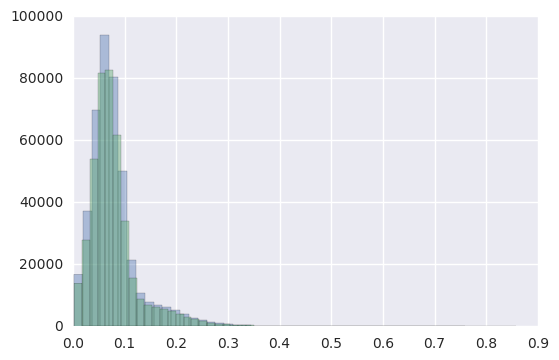

In [225]:

sns.distplot(ytest[:, 2], kde=False)
sns.distplot((ytest1[:, 2] + ytest2[:, 2]) / 2, kde=False)


In [233]:
export_cols = [
        'listing_id', 'image', 
        'seconds_from_min',
        'geometry',
        'geometry_interest_0_mtv',
        'geometry_interest_1_mtv',
        'geometry_interest_2_mtv',
        'filesize',
        'no_pixels'
    ]


df_fold012_res = df_fold012[export_cols + ['interest_level']].copy()
for i in [0, 1, 2]:
    df_fold012_res['interest_level_xgb_%d' % i] = ypred1[:, i]

In [229]:
df_fold345_res = df_fold345[export_cols + ['interest_level']].copy()
for i in [0, 1, 2]:
    df_fold345_res['interest_level_xgb_%d' % i] = ypred2[:, i]

In [235]:
df_test_res = df_test[export_cols].copy()
for i in [0, 1, 2]:
    df_test_res['interest_level_xgb_%d' % i] = ytest[:, i]

In [ ]:
feather.